### Import all dependencies

In [2]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

### Define Few Parameters

In [3]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
pneumonia_path = 'C:/Users/admin/PNEUMONIA DETECTION/data/chest/0Chest_PNEUMONIA'
nonpneumonia_path = 'C:/Users/admin/PNEUMONIA DETECTION/data/chest/1Chest_NonPNEUMONIA'

# Use glob to grab images from path .jpg or jpeg
pneumonia_files = glob(pneumonia_path + '/*')
nonpneumonia_files = glob(nonpneumonia_path + '/*')

 Fetch Images and Class Labels from Files

In [5]:
# Preparing Labels
pneumonia_labels = []
nonpneumonia_labels = []

pneumonia_images=[]
nonpneumonia_images=[]

import cv2 

for i in range(len(pneumonia_files)):
  image = cv2.imread(pneumonia_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  pneumonia_images.append(image)
  pneumonia_labels.append('0Chest_PNEUMONIA')
for i in range(len(nonpneumonia_files)):
  image = cv2.imread(nonpneumonia_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  nonpneumonia_images.append(image)
  nonpneumonia_labels.append('1Chest_NonPNEUMONIA')
print("Number of PNEUMONIA images:", len( pneumonia_images))
print("Number of non-PNEUMONIA images:", len(nonpneumonia_images))

Number of PNEUMONIA images: 435
Number of non-PNEUMONIA images: 505


### Visualize First 40 Images from Data set

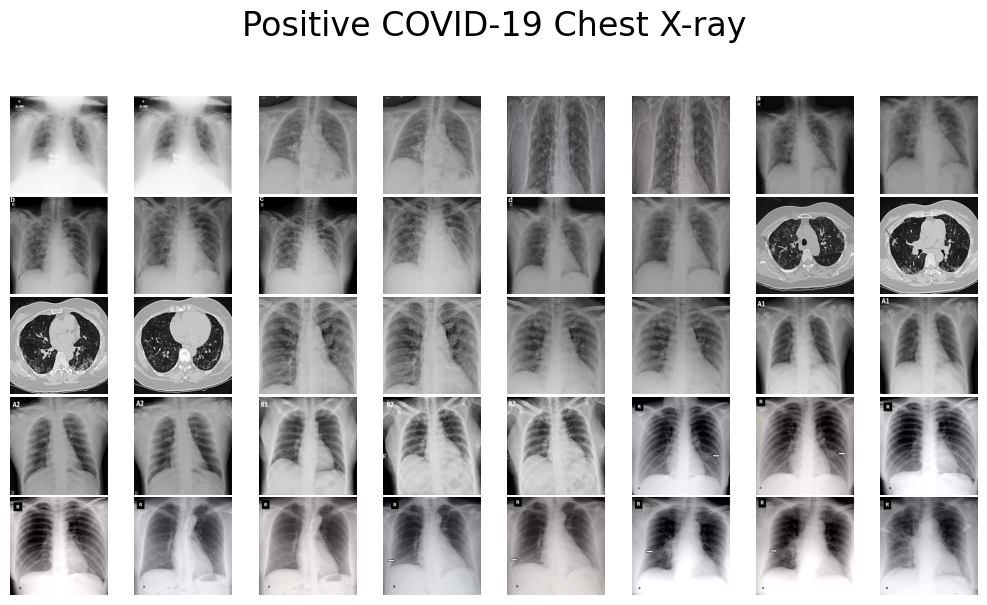

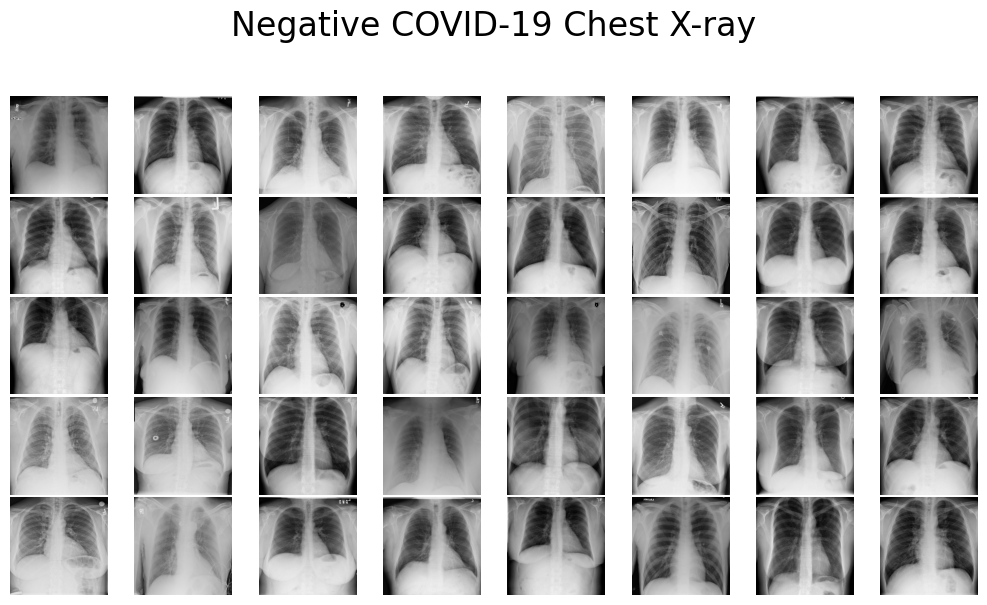

In [39]:
def plot_images(images, title):
    num_images = len(images)
    nrows, ncols = 5, 8
    figsize = [10, 6]

    if num_images < nrows*ncols:
        ncols = num_images//nrows + 1

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        if i < num_images:
            axi.imshow(images[i])
            axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
    
plot_images( pneumonia_images, 'Positive PNEUMONIA Chest X-ray')
plot_images(nonpneumonia_images, 'Negative PNEUMONIA Chest X-ray')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [40]:
# normalize to interval of [0,1]
pneumonia_images = np.array( pneumonia_images) / 255
nonpneumonia_images = np.array(nonpneumonia_images) / 255

### **Train Test Split**

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
pneumonia_x_train,  pneumonia_x_test,  pneumonia_y_train,  pneumonia_y_test = train_test_split(
     pneumonia_images,  pneumonia_labels, test_size=0.1)
nonpneumonia_x_train, nonpneumonia_x_test, nonpneumonia_y_train, nonpneumonia_y_test = train_test_split(
    nonpneumonia_images, nonpneumonia_labels, test_size=0.1)




X_train = np.concatenate((nonpneumonia_x_train,  pneumonia_x_train), axis=0)
X_test = np.concatenate((nonpneumonia_x_test,  pneumonia_x_test), axis=0)
y_train = np.concatenate((nonpneumonia_y_train,  pneumonia_y_train), axis=0)
y_test = np.concatenate((nonpneumonia_y_test, pneumonia_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

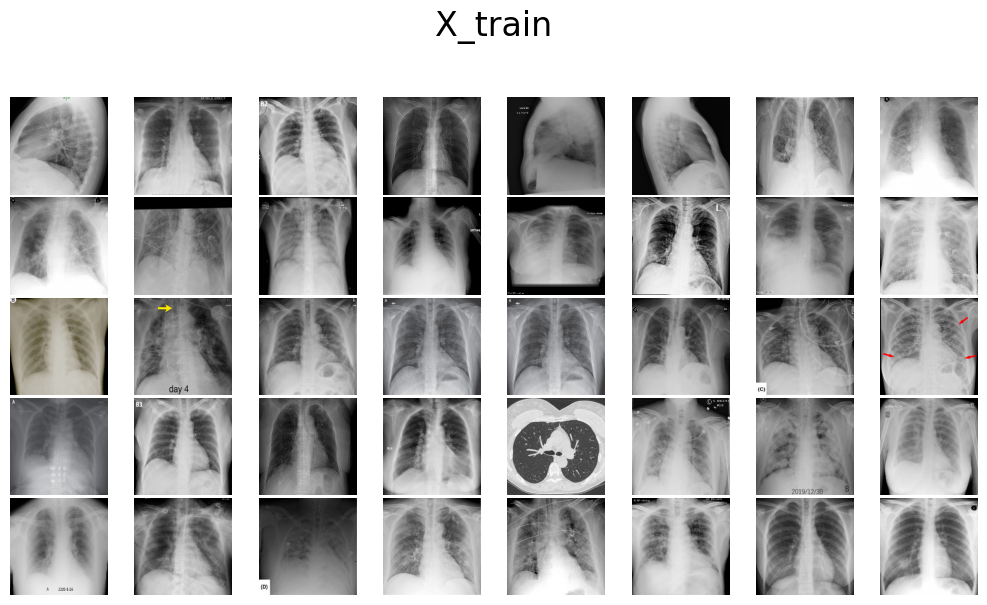

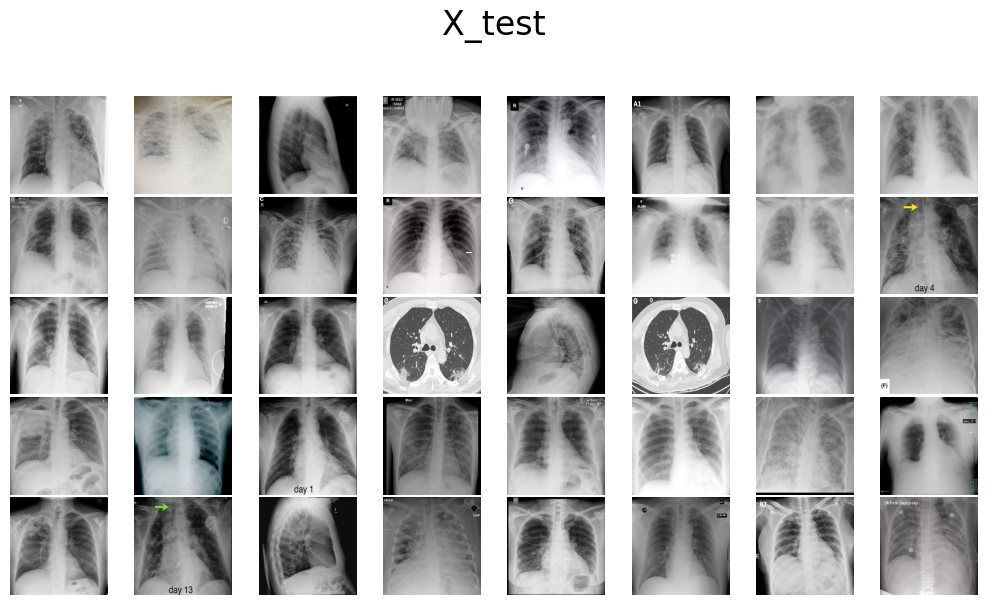

In [42]:
plot_images(pneumonia_x_train, 'X_train')
plot_images(pneumonia_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing PNEUMONIA and NonPNEUMONIA for X_train and X_test

### **Building and Visualizing model**

In [44]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [45]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

 batch_normalization_99 (BatchN  (None, 25, 25, 64)  192         ['conv2d_99[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_101 (Batch  (None, 25, 25, 64)  192         ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 25, 25, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 25, 25, 32)  96          ['conv2d_105[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_116 (Batch  (None, 25, 25, 64)  192         ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 25, 25, 64)   0           ['batch_normalization_116[0][0]']
                                                                                                  
 conv2d_114 (Conv2D)            (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 25, 25, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_128 (Conv2D)            (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 12, 12, 128)  384        ['conv2d_128[0][0]']             
 Normaliza

                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_138 (Conv2D)            (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_138 (Batch  (None, 12, 12, 160)  480        ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 12, 12, 160)  179200      ['activation_138[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 conv2d_149 (Conv2D)            (None, 12, 12, 160)  179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_149 (Batch  (None, 12, 12, 160)  480        ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_149[0][0]']
          

                                                                                                  
 batch_normalization_159 (Batch  (None, 12, 12, 192)  576        ['conv2d_159[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_159[0][0]']
                                                                                                  
 conv2d_155 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_159[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_164 (Conv2D)            (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_168 (Conv2D)            (None, 12, 12, 192)  258048      ['activation_167[0][0]']         
                                                                                                  
 batch_normalization_164 (Batch  (None, 12, 12, 192)  576        ['conv2d_164[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_168 (Batch  (None, 12, 12, 192)  576        ['conv2d_168[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_170 (Batch  (None, 5, 5, 320)   960         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_172 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_172[0][0]']
                                                                                                  
 activation_173 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_173[0][0]']
                                                                                                  
 activation_176 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_177[0][0]']
          

                                                                                                  
 activation_185 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_185[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 5, 5, 384)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 batch_normalization_187 (Batch  (None, 5, 5, 192)   576         ['conv2d_187[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 5, 5, 320)    0           ['batch_normalization_179[0][0]']
                                                                                                  
 mixed9_1 

### **Training the model**

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=500)

Epoch 1/500
26/26 [==============================] - 214s 8s/step - loss: 3.0343 - accuracy: 0.6757 - val_loss: 1.9879 - val_accuracy: 0.7579
Epoch 2/500
26/26 [==============================] - 243s 9s/step - loss: 1.9472 - accuracy: 0.7870 - val_loss: 1.3493 - val_accuracy: 0.8000
Epoch 3/500
26/26 [==============================] - 234s 9s/step - loss: 1.2349 - accuracy: 0.8367 - val_loss: 1.5377 - val_accuracy: 0.7368
Epoch 4/500
27/26 [==============================] - ETA: -5s - loss: 0.8135 - accuracy: 0.8426

In [0]:
model.save('inceptionv3_chest.h5')

In [0]:
model.save_weights('inceptionv3_chest.hdf5')

In [0]:
model = load_model('inceptionv3_chest.h5')

### **Making Predicions**

In [0]:
y_pred = model.predict(X_test, batch_size=batch_size)

### Visulaizing First 10 predictions

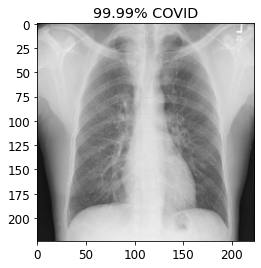

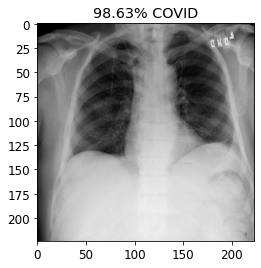

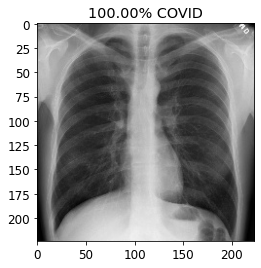

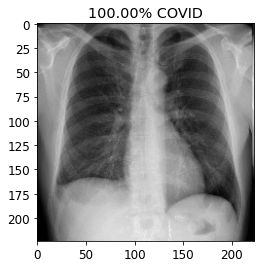

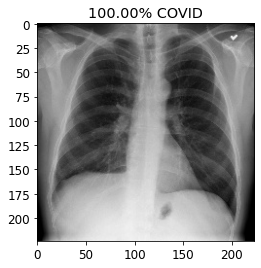

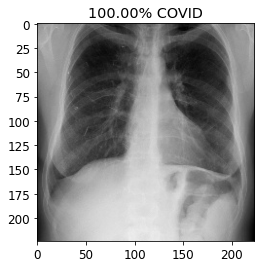

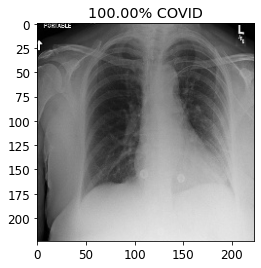

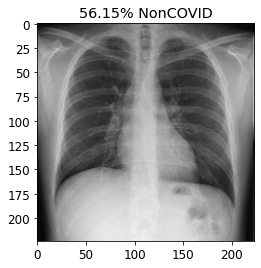

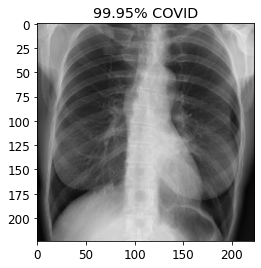

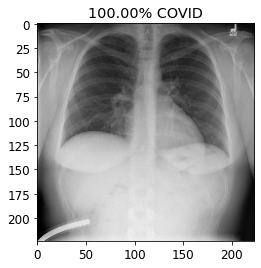

In [28]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% PNEUMONIA')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonPNEUMONIA')
  plt.imshow(X_test[index])
  plt.show()

In [0]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

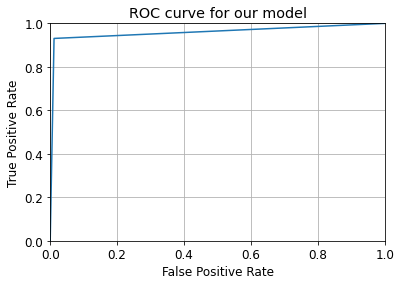

In [30]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

In [6]:
def plot_confusion_matrix(normalize):
  classes = ['PNEUMONIA','NonPNEUMONIA']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

Confusion Matrix without Normalization


NameError: name 'y_test_bin' is not defined

### **Classification Report**

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96        87
           1       0.99      0.93      0.96       101

    accuracy                           0.96       188
   macro avg       0.96      0.96      0.96       188
weighted avg       0.96      0.96      0.96       188



### **Accuracy and Loss Plots**

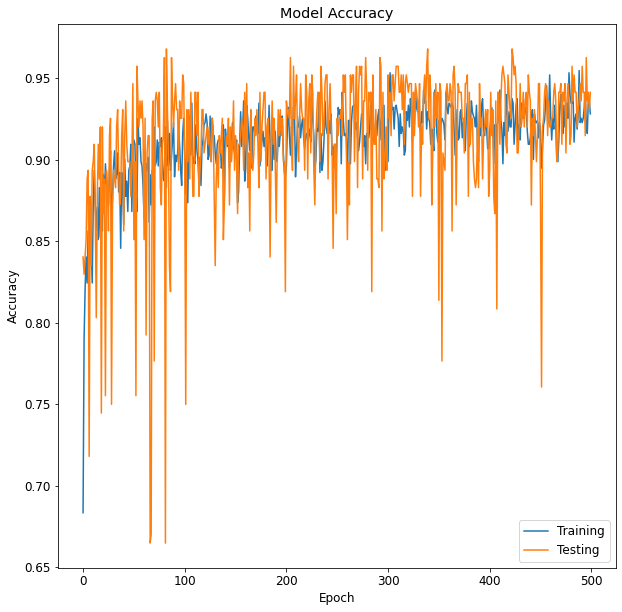

In [23]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_chest_accuracy.png')
plt.show()


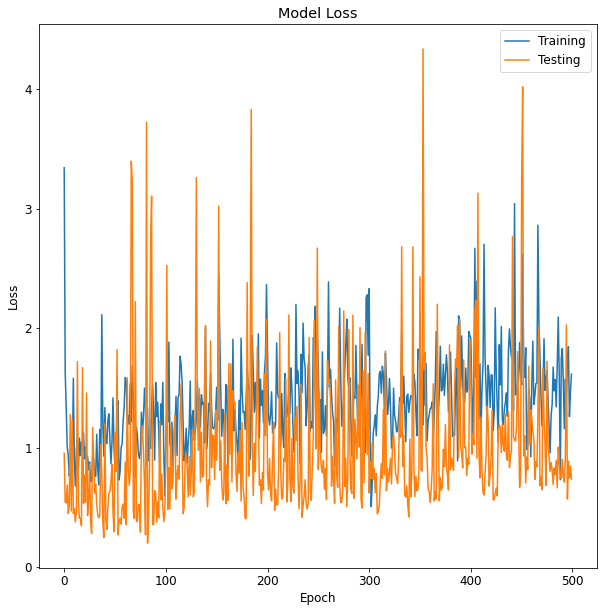

In [24]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_chest_loss.png')
plt.show()